# Imports and setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Flatten, Input, Embedding, Dot
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, LearningRateScheduler

from wordcloud import WordCloud
%matplotlib inline

# from google.colab import drive
# drive.mount('/content/drive')

# Reading Data from animelist

In [2]:
INPUT_DIR = os.path.join('..','artifacts','raw')
#INPUT_DIR = '/content/drive/MyDrive/'
INPUT_DIR

'../artifacts/raw'

In [3]:
rating_df = pd.read_csv(INPUT_DIR+'/animelist.csv', low_memory=True, usecols=['user_id','anime_id','rating'])
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


## EDA

In [4]:
f'{len(rating_df):,}'

'5,000,000'

In [5]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 114.4 MB


In [6]:
# Descriptive statistics for ratings

rating_df.rating.describe()

count    5.000000e+06
mean     4.306854e+00
std      3.906990e+00
min      0.000000e+00
25%      0.000000e+00
50%      6.000000e+00
75%      8.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

We need to figure out the experiened and active users who can help in the reccomendation system

In [7]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [8]:
# The number of ratings each user has given which indicates how experienced that user is
n_ratings = rating_df.user_id.value_counts()
n_ratings

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
9442         1
449          1
443          1
12314        1
16074        1
Name: count, Length: 15186, dtype: int64

In [9]:

rating_df = rating_df[rating_df.user_id.isin(n_ratings[n_ratings>=400].index)].copy()

In [10]:
len(rating_df)

3246641

### Feature scaling
Since the ratings are in a range of 0-10, we would scale it using min max scaling to normalise the values to a range of 0-1

In [11]:
min_rating = min(rating_df.rating)
max_rating = max(rating_df.rating)
min_rating, max_rating

(0, 10)

In [12]:
rating_df['rating'] = rating_df.rating.apply(lambda x: (x-min_rating)/(max_rating-min_rating))


In [13]:
rating_df.rating.describe()

count    3.246641e+06
mean     4.122733e-01
std      3.845031e-01
min      0.000000e+00
25%      0.000000e+00
50%      5.000000e-01
75%      8.000000e-01
max      1.000000e+00
Name: rating, dtype: float64

### Check for duplicates and nulls

In [14]:
rating_df.duplicated().sum()

np.int64(0)

In [15]:
rating_df.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

### Encode user and anime ids

In [16]:
user_ids = rating_df.user_id.unique().tolist()
anime_ids = rating_df.anime_id.unique().tolist()
n_users = len(user_ids)
n_anime = len(anime_ids)
print(f'Number of unique users: {n_users}\nNumber of animes: {n_anime}')

Number of unique users: 4203
Number of animes: 17149


In [17]:
encoded_user = {x : i for i , x in enumerate(user_ids)}
decoded_user = {i : x for i , x in enumerate(user_ids)}
rating_df["user"] = rating_df.user_id.map(encoded_user)

encoded_anime = {x:i for i,x in enumerate(anime_ids)}
decoded_anime = {i:x for i,x in enumerate(anime_ids)}
rating_df['anime'] = rating_df.anime_id.map(encoded_anime)

rating_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


In [18]:
# Shuffle the data
rating_df = rating_df.sample(frac=1, random_state=42).reset_index(drop=True)
rating_df.head()

,user_id,anime_id,rating,user,anime
0,13338,30,0.7,3405,688
1,15967,15583,0.6,4060,1518
2,4967,39586,0.0,1213,4963
3,4055,8039,0.0,997,4097
4,6170,30205,0.0,1552,1690


## Train Test Split

In [19]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,13338,30,0.7,3405,688
1,15967,15583,0.6,4060,1518


In [20]:
X = rating_df[['user','anime']].values
y = rating_df['rating']

In [21]:
test_size = 1000
train_idx = rating_df.shape[0] - test_size

In [22]:
X_train, X_test, y_train, y_test = (
    X[:train_idx],
    X[train_idx:],
    y[:train_idx],
    y[train_idx:]
)


In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3245641, 2), (1000, 2), (3245641,), (1000,))

In [24]:
X_train_array = [X_train[: , 0] , X_train[: ,1]]
X_test_array = [X_test[: , 0] , X_test[: ,1]]

## Model Architecture

In [25]:
def RecommenderNet():
    """
    Builds and returns a deep learning-based collaborative filtering recommender model using user and anime embeddings.

    The model learns latent features for users and anime through embedding layers,
    computes the cosine similarity between them, and uses a sigmoid output to predict
    the probability that a user will like a given anime.

    Returns:
        model (tf.keras.Model): A compiled Keras model ready for training.
    """
    
    embedding_size = 128  # Size of the embedding vector for both users and anime

    # Input layer for user ID (expects a single integer per input)
    user = Input(name="user", shape=[1])

    # Embedding layer to learn a dense representation of users
    user_embedding = Embedding(
        name="user_embedding",
        input_dim=n_users,               # Total number of unique users
        output_dim=embedding_size        # Size of the embedding vector
    )(user)

    # Input layer for anime ID (expects a single integer per input)
    anime = Input(name="anime", shape=[1])

    # Embedding layer to learn a dense representation of anime
    anime_embedding = Embedding(
        name="anime_embedding",
        input_dim=n_anime,               # Total number of unique animes
        output_dim=embedding_size
    )(anime)

    # Dot product of normalized embeddings (cosine similarity)
    x = Dot(
        name="dot_product",
        normalize=True,                  # Normalize vectors before dot product = cosine similarity
        axes=2
    )([user_embedding, anime_embedding])

    # Flatten the result to a 1D tensor
    x = Flatten()(x)

    # Dense layer to transform the similarity score
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    model = Model(inputs=[user, anime], outputs=x)

    # Compile the model with binary crossentropy loss and Adam optimizer
    model.compile(
        loss="binary_crossentropy",     
        metrics=["mae", "mse"],         
        optimizer=Adam()
    )

    return model


In [26]:
model = RecommenderNet()

In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [28]:
# Learning rate schedule parameters
start_lr = 0.00001   # Starting LR at epoch 0
max_lr = 0.0001      # Peak LR reached after ramp-up
min_lr = 0.00005     # Final LR after decay


rampup_epochs = 5    # Number of epochs to linearly increase LR
sustain_epochs = 0   # Number of epochs to sustain max LR before decay
exp_decay = 0.8      # Exponential decay rate after ramp-up/sustain

# Based on stack overflow post: 
# https://stackoverflow.com/questions/61520180/how-to-improve-val-loss-and-val-acc
def lrfn(epoch):
    if epoch < rampup_epochs:
        # Linear ramp-up from start_lr to max_lr
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        # Sustain max_lr for sustain_epochs
        return max_lr
    else:
        # Exponential decay from max_lr down to min_lr
        return (max_lr - min_lr) * exp_decay ** (epoch - rampup_epochs - sustain_epochs) + min_lr


In [29]:
checkpoint_filepath = './weights.weights.h5'

In [30]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch) , verbose=0)

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                   save_weights_only=True,
                                   monitor="val_loss",
                                   mode="min",
                                   save_best_only=True)

early_stopping = EarlyStopping(patience=5,
                               monitor="val_loss",
                               mode="min",
                               restore_best_weights=True)

In [31]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [33]:
batch_size = 10000

history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data = (X_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.7020 - mae: 0.3630 - mse: 0.1599 - val_loss: 0.6920 - val_mae: 0.3627 - val_mse: 0.1564 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.7003 - mae: 0.3625 - mse: 0.1590 - val_loss: 0.6911 - val_mae: 0.3617 - val_mse: 0.1559 - learning_rate: 2.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.6965 - mae: 0.3612 - mse: 0.1571 - val_loss: 0.6898 - val_mae: 0.3614 - val_mse: 0.1553 - learning_rate: 4.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.6917 - mae: 0.3599 - mse: 0.1548 - val_loss: 0.6882 - val_mae: 0.3614 - val_mse: 0.1545 - learning_rate: 6.4000e-05
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.6865 - mae: 0.3582 - mse: 0.1522 - val_loss: 0.6822 - val_mae: 0.3599 - val_mse: 0.1515 - learning_rate: 8.2000e-05
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.6772 - mae: 0.3534 - mse: 0.1476 - val_los

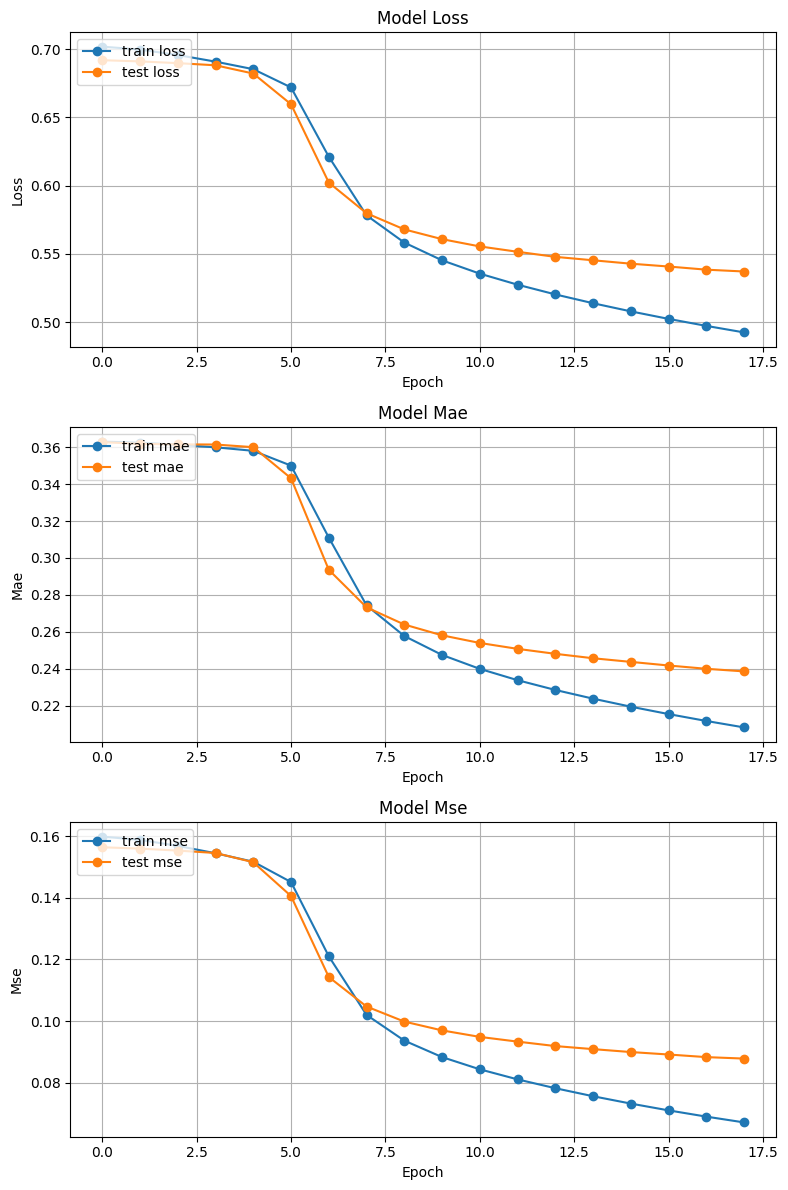

In [34]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [35]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [36]:
anime_weights = extract_weights("anime_embedding",model)
user_weights = extract_weights("user_embedding",model)

In [37]:
anime_weights.shape, user_weights.shape

((17149, 128), (4203, 128))

In [38]:
checkpoint_filepath = './weights.weights.h5'
model.load_weights(checkpoint_filepath)

# Read data from anime.csv

In [39]:
df = pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [40]:
df = df.replace("Unknown",np.nan)

In [41]:
df.rename({'MAL_ID':'anime_id', 'English name':'eng_version'}, axis=1, inplace=True)

In [42]:
df.columns

Index(['anime_id', 'Name', 'Score', 'Genres', 'eng_version', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')

In [64]:
def getAnimeName(anime_id):
    try:
        row = df[df.anime_id == anime_id].iloc[0]
        name = row.Name if pd.isna(row.eng_version) else row.eng_version
        return name
    except IndexError:
        print(f"Anime ID {anime_id} not found in DataFrame.")
    except Exception as e:
        print(f"Unexpected error while retrieving anime name: {e}")
    return None

In [67]:
getAnimeName(6704)

"Queen's Blade:The Exiled Virgin"